In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchmetrics import MeanSquaredError
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning import Callback
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
data = pd.read_csv('../input/us-patent-phrase-to-phrase-matching/train.csv')
test_data = pd.read_csv('../input/us-patent-phrase-to-phrase-matching/test.csv')
data.shape, test_data.shape


((36473, 5), (36, 4))

In [3]:
data.head()

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


In [4]:
codes = pd.read_csv('../input/cpc-codes/titles.csv')
codes = codes.rename(columns = {"code" : "context"})
codes.head()

,context,title,section,class,subclass,group,main_group
0,A,HUMAN NECESSITIES,A,NaN,NaN,NaN,NaN
1,A01,AGRICULTURE; FORESTRY; ANIMAL HUSBANDRY; HUNTI...,A,1.0,NaN,NaN,NaN
2,A01B,SOIL WORKING IN AGRICULTURE OR FORESTRY; PARTS...,A,1.0,B,NaN,NaN
3,A01B1/00,Hand tools (edge trimmers for lawns A01G3/06 ...,A,1.0,B,1.0,0.0
4,A01B1/02,Spades; Shovels {(hand-operated dredgers E02F3...,A,1.0,B,1.0,2.0


In [5]:
train_data=pd.merge(data,codes[["context","title"]],on="context",how="left")
test_data=pd.merge(test_data,codes[["context","title"]],on="context",how="left")

In [6]:
class CFG:
    val_size = 0.20
    max_len = 128
    model_name = '../input/bert-for-patent/bert-for-patents'
    batch_size = 32
    epochs = 50
    lr = 0.001158
    max_lr = 1e-3
    steps_per_epoch = None
    pct_start = 0.3
    div_factor = 1e+2
    final_div_factor = 1e+4
    accumulate = 1
    patience = 3
    monitor = 'val_loss'
    seed = 42
    debug = False


In [7]:
class PhraseSimilarityDataset(Dataset):
    
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer
        
        self.tokenizer_params = {
            'max_length' : CFG.max_len,
            'padding' : 'max_length',
            'truncation' : True
        }
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index):
        anchor = self.df.anchor.iloc[index].lower()
        target = self.df.target.iloc[index].lower()
        title = self.df.title.iloc[index].lower()
        
        tokens = self.tokenizer(anchor + '[SEP]' + target + '[SEP]' + title, **self.tokenizer_params)
        
        score = torch.tensor(self.df.score.iloc[index], dtype=torch.float32)
        
        return (
            np.array(tokens['input_ids']),
            np.array(tokens['attention_mask']),
            score
        )
    
class PhraseSimilarityTestset(Dataset):
    
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer
        
        self.tokenizer_params = {
            'max_length' : CFG.max_len,
            'padding' : 'max_length',
            'truncation' : True
        }
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index):
        anchor = self.df.anchor.iloc[index].lower()
        target = self.df.target.iloc[index].lower()
        title = self.df.title.iloc[index].lower()
        
        tokens = self.tokenizer(anchor + '[SEP]' + target + '[SEP]' + title, **self.tokenizer_params)
        
        return (
            np.array(tokens['input_ids']),
            np.array(tokens['attention_mask']),
        )


In [8]:
class PhraseSimilarityModelImpl(nn.Module):
    
    def __init__(self, model_name):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.head = nn.Linear(1024, 1, bias=True)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, text, mask):
        feats = self.bert(text, mask)
        feats = torch.sum(feats[0], 1)/feats[0].shape[1]
        feats = self.dropout(feats)
        output = self.head(feats)
        return output

class PhraseSimilarityModel(pl.LightningModule):
    
    def __init__(self, model, criterion, metric):
        super(PhraseSimilarityModel, self).__init__()
        self.model = model
        self.criterion = criterion
        self.metric = metric
        
    def forward(self, text, mask):
        return self.model(text, mask)
    
    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=CFG.lr)
        return self.optimizer
    
    def training_step(self, batch, batch_idx):
        ids, mask = batch[0], batch[1]
        preds = self.model(ids, mask)
        loss = self.criterion(preds.squeeze(1), batch[2])
        rmse = self.metric(preds.squeeze(1), batch[2])
        logs = {'train_loss': loss, 'train_error': rmse, 'lr': self.optimizer.param_groups[0]['lr']}
        self.log_dict(logs, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        ids, mask = batch[0], batch[1]
        preds = self.model(ids, mask)
        loss = self.criterion(preds.squeeze(1), batch[2])
        rmse = self.metric(preds.squeeze(1), batch[2])
        logs = {'val_loss': loss, 'val_error': rmse}
        self.log_dict(logs, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def predict_step(self, batch, batch_idx):
        ids, mask = batch[0], batch[1]
        preds = self.model(ids, mask)
        return preds
        

In [9]:
if CFG.debug == True:
    train_data = train_data.iloc[:200]
    
scores = train_data.score.values
train_data.drop('score', inplace=True, axis=1)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, scores, 
                                                                  stratify=scores, 
                                                                  test_size=CFG.val_size, 
                                                                  random_state=CFG.seed)
train_data['score'] = train_labels
val_data['score'] = val_labels

tokenizer = AutoTokenizer.from_pretrained(CFG.model_name)
train_dataset = PhraseSimilarityDataset(train_data, tokenizer)
val_dataset = PhraseSimilarityDataset(val_data, tokenizer)
test_dataset = PhraseSimilarityTestset(test_data, tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=CFG.batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False)


In [10]:
CFG.steps_per_epoch = len(train_dataloader)
CFG.steps_per_epoch

912

In [11]:
logger = CSVLogger(save_dir='./', name=CFG.model_name.split('/')[-1]+'_log')
logger.log_hyperparams(CFG.__dict__)
checkpoint_callback = ModelCheckpoint(monitor=CFG.monitor,
                                      save_top_k=1,
                                      save_last=True,
                                      save_weights_only=True,
                                      filename='{epoch:02d}-{valid_loss:.4f}-{valid_acc:.4f}',
                                      verbose=False,
                                      mode='min')
early_stop_callback = EarlyStopping(monitor=CFG.monitor, 
                                    patience=CFG.patience, 
                                    verbose=False, 
                                    mode="min")

trainer = Trainer(
    max_epochs=CFG.epochs,
    gpus=[0],
    accumulate_grad_batches=CFG.accumulate,
    callbacks=[checkpoint_callback, early_stop_callback], 
    logger=logger,
    weights_summary='top',
)

In [12]:
model = PhraseSimilarityModelImpl(CFG.model_name)
criterion = nn.HuberLoss(reduction='mean', delta=1.0)
metric = MeanSquaredError()
driver = PhraseSimilarityModel(model, criterion, metric)

trainer.fit(driver, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)



Some weights of the model checkpoint at ../input/bert-for-patent/bert-for-patents were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/core/saving.py:404: UserWarning: Skipping 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

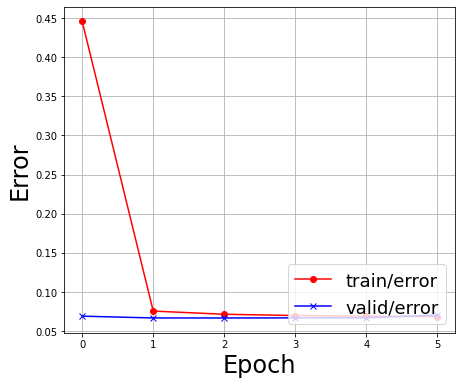

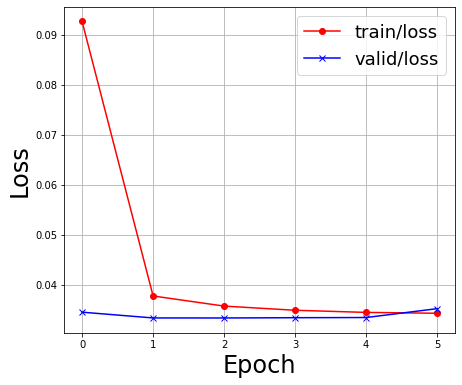

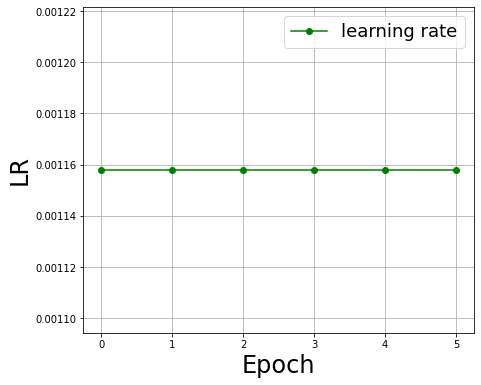

In [13]:
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')

train_acc = metrics['train_error'].dropna().reset_index(drop=True)
valid_acc = metrics['val_error'].dropna().reset_index(drop=True)
    
fig = plt.figure(figsize=(7, 6))
plt.grid(True)
plt.plot(train_acc, color="r", marker="o", label='train/error')
plt.plot(valid_acc, color="b", marker="x", label='valid/error')
plt.ylabel('Error', fontsize=24)
plt.xlabel('Epoch', fontsize=24)
plt.legend(loc='lower right', fontsize=18)
plt.savefig(f'{trainer.logger.log_dir}/acc.png')

train_loss = metrics['train_loss'].dropna().reset_index(drop=True)
valid_loss = metrics['val_loss'].dropna().reset_index(drop=True)

fig = plt.figure(figsize=(7, 6))
plt.grid(True)
plt.plot(train_loss, color="r", marker="o", label='train/loss')
plt.plot(valid_loss, color="b", marker="x", label='valid/loss')
plt.ylabel('Loss', fontsize=24)
plt.xlabel('Epoch', fontsize=24)
plt.legend(loc='upper right', fontsize=18)
plt.savefig(f'{trainer.logger.log_dir}/loss.png')\

lr = metrics['lr'].dropna().reset_index(drop=True)

fig = plt.figure(figsize=(7, 6))
plt.grid(True)
plt.plot(lr, color="g", marker="o", label='learning rate')
plt.ylabel('LR', fontsize=24)
plt.xlabel('Epoch', fontsize=24)
plt.legend(loc='upper right', fontsize=18)
plt.savefig(f'{trainer.logger.log_dir}/lr.png')


In [14]:
predictions = trainer.predict(dataloaders=test_dataloader)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1445: UserWarning: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `predict(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."


Predicting: 912it [00:00, ?it/s]

In [15]:
preds = []
for batch in predictions:
    preds += batch.squeeze(1).tolist()

submission_csv = pd.read_csv('../input/us-patent-phrase-to-phrase-matching/sample_submission.csv')
submission_csv['score'] = preds
submission_csv.head()


,id,score
0,4112d61851461f60,0.366855
1,09e418c93a776564,0.366855
2,36baf228038e314b,0.366855
3,1f37ead645e7f0c8,0.366855
4,71a5b6ad068d531f,0.366855


In [16]:
submission_csv.to_csv('submission.csv', index=False)